# Characterizing the system

In [Part 1](../../../notebooks/workflow/workflow01.md) of this series we described the physical system, including an idealized physics model:

```{image} _static/dc_motor.png
:class: only-light
```

```{image} _static/dc_motor_dark.png
:class: only-dark
```

Our first job is to see how well this model matches reality.

We will do this by collecting data from "step" and "ramp" response sequences using the real hardware and comparing to our idealized model.

This task is made somewhat difficult by the fact that while some parameters (like resistance $R$ and gear ratio $G$) are directly measurable or known from a datasheet, others (like the back EMF constant $k_\mathcal{E}$ or viscous friction $b$) are unknown.

Depending on how many such unknown parameters there are and how sensitive the model is to them, it may be feasible to simply manually tune the parameters until the model matches the data as well as possible.
A somewhat more automated approach is to sweep over parameters or perform a Monte Carlo search and simply pick the best of the candidate parameter sets.

Obviously, both approaches becomes increasingly difficult for more complex systems with large numbers of parameters.
Instead, we will use _parameter estimation_ to determine all the parameters at once as an optimization problem.
For more background, see the [tutorial](../sysid/parameter-estimation.md) on parameter estimation in Archimedes.

In [ ]:
# ruff: noqa: E741, N802, N803, N806, N815, N816
import dataclasses
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

import archimedes as arc
from archimedes.docs.utils import extract_py_class, extract_py_function

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

## Data collection

The linearity of our model guarantees that very simple I/O data will suffice for fully characterizing the system.
Here we will mainly rely on a step response, meaning that the motor initially begins at rest with zero current and then we apply a constant input and record the transient.
The code can also be modified to collect "ramp" data where we increment and hold the input levels to characterize the steady-state relationship between pulse width modulation (PWM) duty cycle and motor voltage.

At this stage we are using the microcontroller purely for data collection, so there is no real need to make use of C code generation functionality yet.
STM32CubeMX will autogenerate boilerplate code for peripheral configuration, and the rest of the code serves to collect the raw data, apply scaling and conversion factors, and then send the data back to the computer via the ST-Link USB connection.
The source code can be found on [GitHub](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/stm32/step_response/) - simply load the `.ioc` file in CubeMX, regenerate the configuration code (be sure that the CMake toolchain is selected in Project Manager > Toolchain / IDE), and then build from the project directory with:

```bash
cd stm32/step_response
cmake --preset=Release && cmake --build --preset=Release
```

One note on USB communication: to enable USART TX/RX mode through the same ST-Link debugger port we're using to flash the firmware, the solder bridges SB4 and SB7 need to be removed.
Once that's done and the rest of the circuit is assembled, the firmware can be deployed to the board using OpenOCD (also from the project directory):

```bash
openocd -f interface/stlink.cfg -f target/stm32f4x.cfg \
        -c "program build/Release/step_response.elf verify reset exit"
```

The onboard blue LED should blink for one second, and then the board will wait for the USER button to be pressed to initiate the control sequence.
The control sequence happens in two stages: a 200 ms step response, and a 20 sec ramp response.

After each stage the microcontroller will transmit the recorded data back to the computer.
We can receive and save this data using the `serial_receive.py` script (from this directory):

```bash
python serial_receive.py --save step_data.csv
```

Once that's ready (you should see `"Waiting for experiment data..."`), go ahead and press the USER button to trigger the step response.  This will save the data in `data/` with the specified filename.

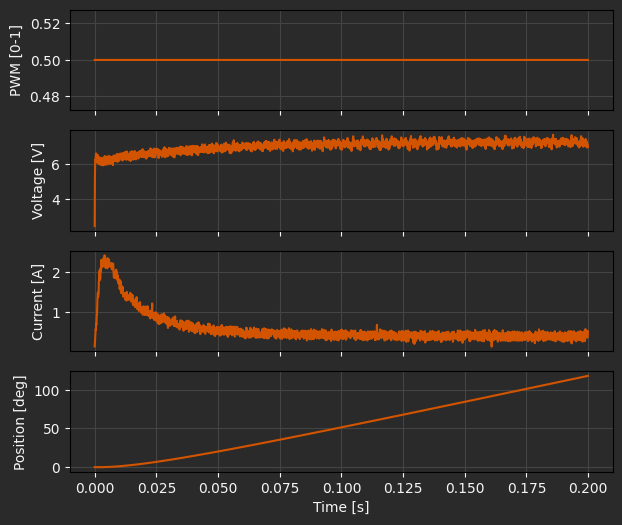

In [3]:
step_data = np.loadtxt("data/step_data.csv", delimiter="\t", skiprows=1)

fig, ax = plt.subplots(4, 1, figsize=(7, 6), sharex=True)

ax[0].plot(step_data[:, 0], step_data[:, 1])
ax[0].set_ylabel("PWM [0-1]")
ax[0].grid()

ax[1].plot(step_data[:, 0], step_data[:, 2])
ax[1].set_ylabel("Voltage [V]")
ax[1].grid()

ax[2].plot(step_data[:, 0], step_data[:, 3])
ax[2].set_ylabel("Current [A]")
ax[2].grid()

ax[3].plot(step_data[:, 0], step_data[:, 4])
ax[3].set_ylabel("Position [deg]")
ax[3].grid()

ax[-1].set_xlabel("Time [s]")

plt.show()



If you're following along with code and not building the physical system, this data can be downloaded from GitHub.

## Model implementation

The idealized physics model for the DC motor is:

$$
\begin{align*}
L \frac{di}{dt} &= V - iR - k_\mathcal{E} \omega \\
J \frac{d\omega}{dt} &= k_\mathcal{\tau} i - b \omega,
\end{align*}
$$

where energy conservation requires that $k_\tau = G k_\mathcal{E}$ for gear ratio $G$ (specified in the [motor datasheet](https://www.pololu.com/file/0J1829/pololu-25d-metal-gearmotors.pdf)).

We'll be reusing the same code for the rest of this series, so for consistency we will use a common implementation in [`motor.py`](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/motor.py) and extract relevant parts of the code.
The model implementation follows the patterns described in the [structured data types](../../../trees.md) and [hierarchical design](../modular-design.md) documentation pages - defining structured classes for parameters, state, etc.

For a relatively simple system like a DC motor, this may seem like overkill, but it pays dividends for more complex systems that can be naturally represented with hierarchical data structures.
As we will see, it also leads to more readable auto-generated C code.

In [4]:
from motor import MotorParams, motor_obs, motor_ode

extract_py_class("motor.py", "MotorParams")
extract_py_function("motor.py", "motor_ode")
extract_py_function("motor.py", "motor_obs")

```python
@struct
class MotorParams:
    J: float  # Effective inertia
    b: float  # Viscous friction
    L: float  # Motor inductance [H]
    R: float  # Motor resistance [Ohm]
    kt: float  # Current -> torque scale [N-m/A]
```

```python
def motor_ode(
    t: float, x: np.ndarray, u: np.ndarray, params: MotorParams
) -> np.ndarray:

    i, _pos, vel = x
    (V,) = u

    ke = params.kt / GEAR_RATIO  # Velocity -> Back EMF scale

    i_t = (1 / params.L) * (V - (i * params.R) - ke * vel)
    vel_t = (1 / params.J) * (params.kt * i - params.b * vel)

    return np.hstack([i_t, vel, vel_t])
```

```python
def motor_obs(
    t: float, x: np.ndarray, u: np.ndarray, params: MotorParams
) -> np.ndarray:
    # Measure absolute current and position
    return np.hstack([abs(x[0]), x[1]])
```

Looking ahead to parameter estimation, we'll start with a rough guess of the model parameters and simulate the model to check for obvious numerical problems.
We could simulate this as an ODE using [`arc.odeint`](#archimedes.odeint), but we'll discretize with a fixed-step scheme since we need the discrete-time state-space model for parameter estimation anyway.

Since the time steps are very small and the system is not especially stiff, we can use a simple Euler scheme for efficiency.
This doesn't matter much for running "offline" on a computer, but since real-time simulation performance is critical for HIL testing it's a good idea to make sure we won't run into issues with stability or accuracy.

In [5]:
# Create I/O data: current and position response to voltage input
data = arc.sysid.Timeseries(
    ts=step_data[:, 0],
    us=step_data[:, 2].reshape(1, -1),  # Input voltage
    ys=np.vstack(
        [
            step_data[:, 3].reshape(1, -1),  # Measured current
            np.deg2rad(step_data[:, 4]).reshape(1, -1),  # Measured position (rad)
        ]
    ),
)

nx = 3  # State dimension (current, velocity, position)
nu = 1  # Input dimension (voltage)
ny = 2  # Output dimension (position, current)
dt = data.ts[1] - data.ts[0]

# Discretize the continuous-time ODE using Euler integration
motor_dyn = arc.discretize(motor_ode, dt=dt, method="euler")


# Function to run the model forward in time
def simulate(x0, params: MotorParams):
    xs_pred = np.zeros((nx, len(data.ts)))
    ys_pred = np.zeros((ny, len(data.ts)))

    xs_pred[:, 0] = x0

    for i in range(len(data.ts)):
        ys_pred[:, i] = motor_obs(data.ts[i], xs_pred[:, i], data.us[:, i], params)
        if i < len(data.ts) - 1:
            xs_pred[:, i + 1] = motor_dyn(
                data.ts[i], xs_pred[:, i], data.us[:, i], params
            )

    return xs_pred, ys_pred

Text(0.5, 0, 'Time [s]')

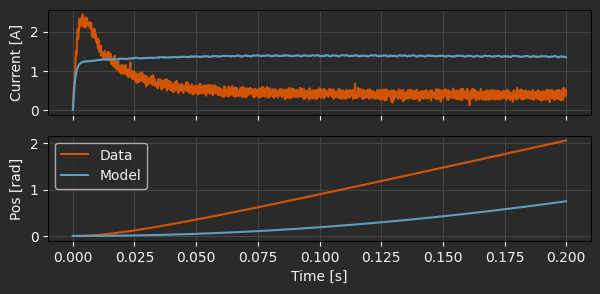

In [6]:
# Initial guess for motor parameters
params_guess = MotorParams(
    J=0.1,
    b=0.1,
    L=5e-3,  # [H]
    R=5.0,  # [Ohm]
    kt=3.0,  # [N-m/A]
)

x0 = np.zeros(3)  # Initial state: zero current, velocity, position

xs_pred, ys_pred = simulate(x0, params_guess)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(data.ts, data.ys[0], label="Data")
ax[0].plot(data.ts, ys_pred[0], label="Model")
ax[0].set_ylabel("Current [A]")
ax[0].grid()

ax[1].plot(data.ts, data.ys[1], label="Data")
ax[1].plot(data.ts, ys_pred[1], label="Model")
ax[1].set_ylabel("Pos [rad]")
ax[1].grid()
ax[1].legend()
ax[-1].set_xlabel("Time [s]")

This is not an especially good fit to the data, but there's also nothing particularly concerning in terms of numerical issues.
Let's move on to fitting the model to the data.

## Parameter estimation

If you haven't already seen the tutorial on [parameter estimation in Archimedes](../sysid/parameter-estimation.md) it may be helpful to read through that for some additional background.
In short, Archimedes uses an implementation of the nonlinear prediction error method (PEM), which is based on the use of Kalman filtering for handling noise and partial observations.
Hence, we first need to set up a Kalman filter for the system.

The state-space model is _almost_ linear (except for the absolute value in the current observation), making the extended Kalman filter a good choice.
To set up the filter we need a discrete state-space model (done) and estimates of the noise covariance for the measurements (current and position) and dynamics.

For the measurement error, we can use a simple estimate based on the variance of the incremental measurements:

$$
\sigma_y^2 \approx \frac{1}{2} \mathrm{Var} \left[ \Delta y \right]
$$

We don't really expect much environmental noise in the velocity and position dynamics, but there may be some electrical noise, so it's reasonable to use a small value for the current dynamics.

In [7]:
# Noise estimates
noise_i = 0.5 * np.var(np.diff(data.ys[0]))  # Estimated current noise
noise_p = 0.5 * np.var(np.diff(data.ys[1]))  # Estimated position noise

R = np.diag([noise_i, noise_p])  # Measurement noise
Q = np.diag([1e-3, 0.0, 0.0])  # Process noise

# Set up the extended Kalman filter using the discrete state-space model
ekf = arc.observers.ExtendedKalmanFilter(motor_dyn, motor_obs, Q, R)

Now we have everything needed to run the parameter estimation:

In [8]:
result = arc.sysid.pem(ekf, data, params_guess, x0=x0)
params_opt = result.p
params_opt

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         1.2262e+01                                   1.25e+03  
    1           3         6.9485e+00       5.31e+00       7.45e+00     5.98e+00  
    2           6         6.6308e+00       3.18e-01       6.42e+00     2.02e+01  
    3           7         6.5155e+00       1.15e-01       2.09e+00     1.87e+01  
    4           8         6.5061e+00       9.39e-03       1.58e-01     3.45e-01  
    5           9         6.5061e+00       3.45e-06       1.85e-02     1.89e-02  
Both actual and predicted relative reductions in the sum of squares are at most ftol


MotorParams(J=array(0.08910903), b=array(0.81924098), L=array(0.00314336), R=array(2.38683236), kt=array(25.48688943))

Let's see how it compares to the data:

tau_e = 1.32 ms
tau_m = 108.77 ms


Text(0.5, 0, 'Time [s]')

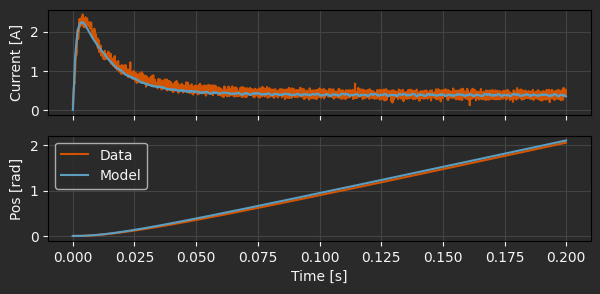

In [13]:
# Time constants
tau_e = params_opt.L / params_opt.R
tau_m = params_opt.J / (params_opt.b)

print(f"tau_e = {tau_e * 1e3:.2f} ms")
print(f"tau_m = {tau_m * 1e3:.2f} ms")

xs_pred, ys_pred = simulate(x0, params_opt)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(data.ts, data.ys[0], label="Data")
ax[0].plot(data.ts, ys_pred[0], label="Model")
ax[0].set_ylabel("Current [A]")
ax[0].grid()

ax[1].plot(data.ts, data.ys[1], label="Data")
ax[1].plot(data.ts, ys_pred[1], label="Model")
ax[1].set_ylabel("Pos [rad]")
ax[1].grid()
ax[1].legend()
ax[-1].set_xlabel("Time [s]")

Not bad!

We'll use these parameters in two places: for controller design, and in a calibrated real-time model for HIL testing.

In [10]:
with open("data/motor_params.pkl", "wb") as f:
    pickle.dump(dataclasses.asdict(params_opt), f)

## Non-ideal effects

Of course, we're cheating a bit here.
We neglected effects like static friction, backlash, and non-ideal power supply behavior in the model, then we collected data and evaluated the model in a scenario where we're unlikely to see any of these effects.
Using voltage as the input variable avoids any questions about the power supply (and from the voltage data we can see that the power supply response is clearly not perfectly steady), and running the motor in one direction with a large step input sidesteps most of the nonlinear friction issues.

Since this is a tutorial about process and not the details of DC gearmotor control we'll ignore all of these shortcomings, but it's worth keeping in mind.
In practice, the "non-ideal" effects that don't show up in an oversimplified test sequence might well be the ones that break your controller!

As a first-order correction we can at least use the "ramp" response data to explore the steady-state relationship between PWM duty cycle, supply voltage, and current.

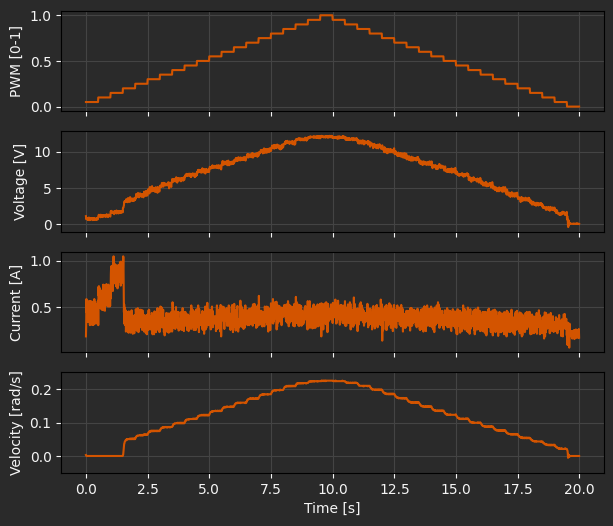

In [11]:
ramp_data = np.loadtxt("data/ramp_data.csv", delimiter="\t", skiprows=1)

# Unwrap the position data
ramp_data[:, 4] = np.unwrap(np.deg2rad(ramp_data[:, 4]))

fig, ax = plt.subplots(4, 1, figsize=(7, 6), sharex=True)

ax[0].plot(ramp_data[:, 0], ramp_data[:, 1])
ax[0].set_ylabel("PWM [0-1]")
ax[0].grid()

ax[1].plot(ramp_data[:, 0], ramp_data[:, 2])
ax[1].set_ylabel("Voltage [V]")
ax[1].grid()

ax[2].plot(ramp_data[:, 0], ramp_data[:, 3])
ax[2].set_ylabel("Current [A]")
ax[2].grid()

# ax[3].plot(ramp_data[:, 0], ramp_data[:, 4])
ax[3].plot(ramp_data[:, 0], np.gradient(ramp_data[:, 4]))
ax[3].set_ylabel("Velocity [rad/s]")
ax[3].grid()
ax[3].set_ylim([-0.05, 0.25])

ax[-1].set_xlabel("Time [s]")

plt.show()

We can already see some interesting effects in this data that indicate some departures from the ideal model.
At low PWM duty cycle values (< 20\%) the current grows rapidly in response to the inputs, but the output shaft doesn't move.
This is evidence of static friction in the system; we need to achieve some threshold breakaway torque to start moving.
The hysteresis at low duty cycle values (especially with velocity) confirms this:

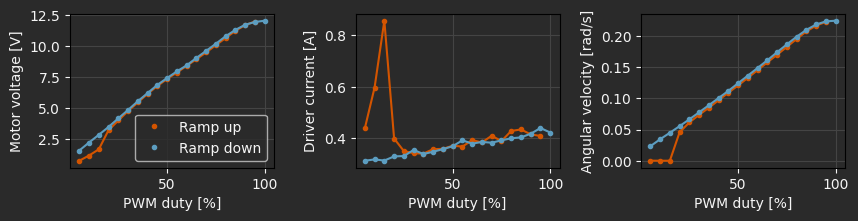

In [12]:
# Voltage and current vs duty cycle
pwm_duty = np.unique(ramp_data[:, 1])
pwm_duty = np.concatenate((pwm_duty[1:], np.flip(pwm_duty[1:-1])))
v_avg = np.zeros_like(pwm_duty)
i_avg = np.zeros_like(pwm_duty)
w_avg = np.zeros_like(pwm_duty)
w = np.gradient(ramp_data[:, 4])  # Angular velocity [rad/s]

start_idx = 0
stop_idx = -1
for i in range(len(pwm_duty)):
    start_idx = stop_idx + 1
    # Stop index is one less than the next index where the duty cycle changes
    stop_idx = np.where(ramp_data[start_idx:, 1] != pwm_duty[i])[0][0] + start_idx - 1
    pwm_idx = np.arange(start_idx, stop_idx + 1)

    v_avg[i] = np.mean(ramp_data[pwm_idx, 2])
    i_avg[i] = np.mean(ramp_data[pwm_idx, 3])
    w_avg[i] = np.mean(w[pwm_idx])

n_split = len(pwm_duty) // 2
pwm_up = pwm_duty[:n_split]
pwm_down = pwm_duty[n_split:]

fig, ax = plt.subplots(1, 3, figsize=(10, 2))
(l,) = ax[0].plot(100 * pwm_up, v_avg[:n_split], ".", label="Ramp up")
ax[0].plot(100 * pwm_up, v_avg[:n_split], "-", c=l.get_color())
(l,) = ax[0].plot(100 * pwm_down, v_avg[n_split:], ".", label="Ramp down")
ax[0].plot(100 * pwm_down, v_avg[n_split:], "-", c=l.get_color())
ax[0].set_xlabel("PWM duty [%]")
ax[0].set_ylabel("Motor voltage [V]")
ax[0].grid()
ax[0].legend()

(l,) = ax[1].plot(100 * pwm_up, i_avg[:n_split], ".")
ax[1].plot(100 * pwm_up, i_avg[:n_split], "-", c=l.get_color())
(l,) = ax[1].plot(100 * pwm_down, i_avg[n_split:], ".")
ax[1].plot(100 * pwm_down, i_avg[n_split:], "-", c=l.get_color())
ax[1].set_xlabel("PWM duty [%]")
ax[1].set_ylabel("Driver current [A]")
ax[1].grid()

(l,) = ax[2].plot(100 * pwm_up, w_avg[:n_split], ".")
ax[2].plot(100 * pwm_up, w_avg[:n_split], "-", c=l.get_color())
(l,) = ax[2].plot(100 * pwm_down, w_avg[n_split:], ".")
ax[2].plot(100 * pwm_down, w_avg[n_split:], "-", c=l.get_color())
ax[2].set_xlabel("PWM duty [%]")
ax[2].set_ylabel("Angular velocity [rad/s]")
ax[2].grid()

plt.subplots_adjust(wspace=0.4)
plt.show()

Aside from the hysteresis at small values of the duty cycle, the main non-ideal effect observed here is a saturation of supply voltage at large duty cycle values.
We might expect to see more non-ideal effects with "chirp" tests or with direction reversals, which would test mechanical backlash and higher-frequency electrical dynamics.

However, at low frequencies the behavior remains reasonably linear over a fairly wide range of values, suggesting that the idealized model is a good starting point for controller design.
In [Part 3](workflow03.md) we will design and evaluate a simple position controller using this calibrated dynamics model.